In [2]:
%pwd


'/Users/bhargobdeka/Desktop/Projects/RAG-chatbot-Speckly/app'

In [3]:
import os
os.chdir("..")

In [4]:
%pwd

'/Users/bhargobdeka/Desktop/Projects/RAG-chatbot-Speckly'

In [6]:
import os
import pickle
import sys

# Get the current working directory
current_dir = os.path.dirname("/Users/bhargobdeka/Desktop/Projects/RAG-chatbot-Speckly/app")

# Add the main directory to the Python path
sys.path.append(os.path.dirname(current_dir))

# Add the utils package to the Python path
utils_dir = os.path.join(os.path.dirname(current_dir), 'utils')
sys.path.append(utils_dir)

In [7]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from typing import List, Any, Union, Dict
from utils.vector_store import create_vector_store
from utils.grader import GraderUtils
from utils.graph import GraphState
from utils.generate_chain import create_generate_chain
from utils.nodes import GraphNodes
from utils.edges import EdgeGraph
from langgraph.graph import END, StateGraph
from fastapi import FastAPI
from fastapi.responses import RedirectResponse
from langserve import add_routes
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.output_parsers import StrOutputParser

In [8]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv()) # important line if cannot load api key

## Getting the api keys from the .env file

os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['LANGCHAIN_API_KEY'] = os.getenv('LANGCHAIN_API_KEY')

# WebSearch tools
os.environ['SERPAPI_API_KEY'] = os.getenv('SERPAPI_API_KEY')
os.environ['GOOGLE_API_KEY'] = os.getenv('GOOGLE_API_KEY')
os.environ['GOOGLE_CSE_ID'] = os.getenv('GOOGLE_CSE_ID')
os.environ['TAVILY_API_KEY'] = os.getenv('TAVILY_API_KEY')

# Langsmith Tracing
os.environ['LANGCHAIN_TRACING_V2'] = os.getenv('LANGCHAIN_TRACING_V2')
os.environ['LANGCHAIN_ENDPOINT'] = os.getenv('LANGCHAIN_ENDPOINT')
os.environ['LANGCHAIN_PROJECT'] = os.getenv('LANGCHAIN_PROJECT')

# Fire Crawl API
os.environ['FIRE_API_KEY']=os.getenv('FIRE_API_KEY')

## Create Retriever

# embedding model
embedding_model = OpenAIEmbeddings()

# Load the crawled saved docs from the local file
with open("crawled_docs/saved_docs.pkl", "rb") as f:
    saved_docs = pickle.load(f)

# convert doc list to text strings
# doc_text = [doc.page_content for doc in saved_docs]

# create vector store
store = create_vector_store(saved_docs)

# creating retriever
retriever = store.as_retriever()

## LLM model
llm = ChatOpenAI(model="gpt-4o", temperature=0)


# Create the generate chain
generate_chain = create_generate_chain(llm)

## get the grader instances

# Create an instance of the GraderUtils class
grader = GraderUtils(llm)

# Get the retrieval grader
retrieval_grader = grader.create_retrieval_grader()

# Get the hallucination grader
hallucination_grader = grader.create_hallucination_grader()

# Get the code evaluator
code_evaluator = grader.create_code_evaluator()

# Get the question rewriter
question_rewriter = grader.create_question_rewriter()

## Creating the WorkFlow

# Initiating the Graph
workflow = StateGraph(GraphState)

# Create an instance of the GraphNodes class
graph_nodes = GraphNodes(llm, retriever, retrieval_grader, hallucination_grader, code_evaluator, question_rewriter)

# Create an instance of the EdgeGraph class
edge_graph = EdgeGraph(hallucination_grader, code_evaluator)

# Define the nodes
workflow.add_node("retrieve", graph_nodes.retrieve) # retrieve documents
workflow.add_node("grade_documents", graph_nodes.grade_documents)  # grade documents
workflow.add_node("generate", graph_nodes.generate) # generate answers
workflow.add_node("transform_query", graph_nodes.transform_query)  # transform_query

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    edge_graph.decide_to_generate,
    {
        "transform_query": "transform_query", # "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    edge_graph.grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query", # "transform_query"
    },
)

# Compile
app = workflow.compile()

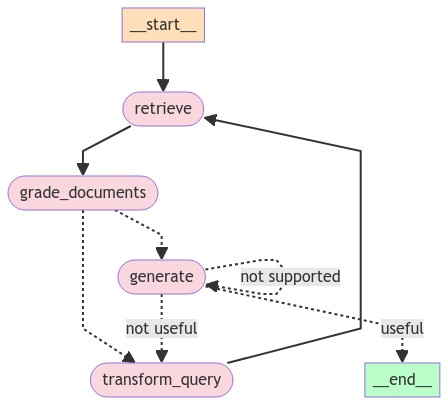

In [9]:
## graph
from langchain_core.runnables.graph import CurveStyle, NodeColors, MermaidDrawMethod
from IPython.display import display, HTML, Image

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)